## Load wine data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)

## Custom functions

In [2]:
def rfc_get_best_oob_score(best_params, X_data, y_data): # only works for random forest
    """Returns the oob score of the RandomForestClassifier with the best parameters."""
    best_rf_clf = RandomForestClassifier(**best_params, random_state=42)
    best_rf_clf.fit(X_data, y_data)
    return best_rf_clf.oob_score_

def rfc_print_feature_importance(best_params, X_data, y_data):
    """Print feature importance of the RandomForestClassifier with the best parameters."""
    best_rf_clf = RandomForestClassifier(**best_params, random_state=42)
    best_rf_clf.fit(X_data, y_data)
    for score, name in zip(best_rf_clf.feature_importances_, X_data.columns):
        print(round(score, 2), name)

## Get and view data

In [3]:
wine_quality = fetch_ucirepo(id=186)
print(wine_quality.variables)

                    name     role         type demographic             description units missing_values
0          fixed_acidity  Feature   Continuous        None                    None  None             no
1       volatile_acidity  Feature   Continuous        None                    None  None             no
2            citric_acid  Feature   Continuous        None                    None  None             no
3         residual_sugar  Feature   Continuous        None                    None  None             no
4              chlorides  Feature   Continuous        None                    None  None             no
5    free_sulfur_dioxide  Feature   Continuous        None                    None  None             no
6   total_sulfur_dioxide  Feature   Continuous        None                    None  None             no
7                density  Feature   Continuous        None                    None  None             no
8                     pH  Feature   Continuous        None      

##### No missing values as expected.

## Load data as a dataframe including the color variable

In [4]:
df_wine = wine_quality['data']['original']
df_wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


##### We have 12 features and one target variable. Our sample is n=6497 observations.
##### Split into red and white dataframe.

In [5]:
df_red = df_wine.query('color == "red"')
df_white = df_wine.query('color == "white"')

## Data exploration

In [6]:
df_wine.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


##### The ranges of the features varies greatly, e.g. sulphates ranges between 0.22 and 2 whereas total_sulfur_dioxide ranges between 6 and 440. However, random forests are generally not sensitive to feature scaling. 
##### Note the target feature in this sample only ranges between 3 and 9 (wines are given a score between 0-10).

## Distribution of the target quality

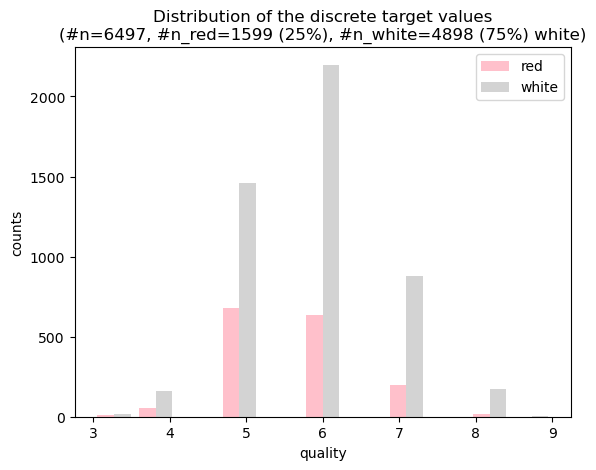

Unique quality scores of red:
[3, 4, 5, 6, 7, 8]

Unique quality scores of white:
[3, 4, 5, 6, 7, 8, 9]


In [7]:
pct_red = round(len(df_red) / len(df_wine) * 100)
pct_white = round(len(df_white) / len(df_wine) * 100)

plt.hist([df_wine.query('color == "red"').quality, df_wine.query('color == "white"').quality], bins=11, stacked=False, color=['pink', 'lightgrey'], label=['red', 'white'])
plt.ylabel('counts')
plt.xlabel('quality')
plt.title(f'Distribution of the discrete target values\n(#n={len(df_wine)}, #n_red={len(df_red)} ({pct_red}%), #n_white={len(df_white)} ({pct_white}%) white)')
plt.legend()
plt.show()
print('Unique quality scores of red:')
print(sorted(df_red.quality.unique()))
print('\nUnique quality scores of white:')
print(sorted(df_white.quality.unique()))

##### The majority of data consists of whites (75%). For both red and white, the majority of quality scores lies around 5-6. The numbers of scores of 5 and 6 for red are about the same, whereas for white there are more quality scores of 6 compared to 5. Note, no reds have a quality score of 9.
##### Overall, for both red and white, the different quality scores are imbalanced due to the large difference in number of wines within each quality score. This could impact how well the model is able to predict high and low quality scores.

## Distribution of features

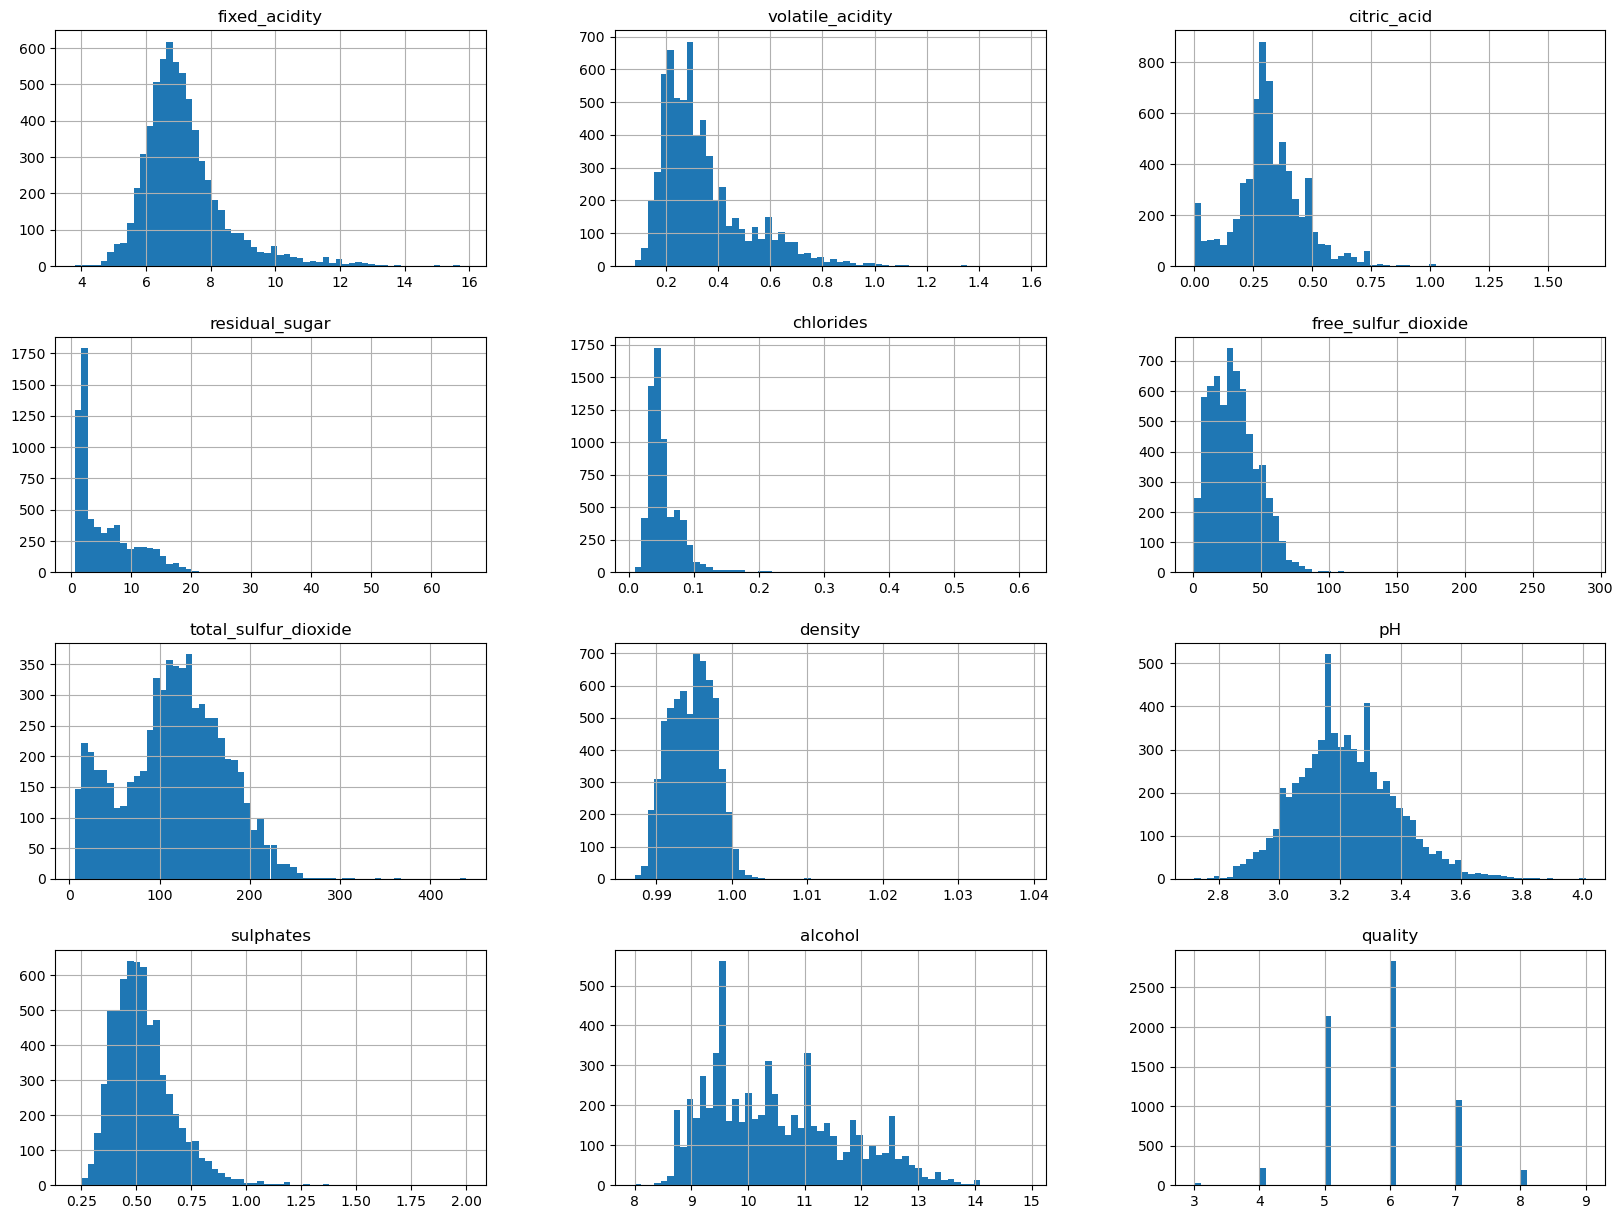

In [8]:
df_wine.hist(bins=60, figsize=(20, 15))
plt.show()

##### The distribution of the features varies in shape. Some are right skewed. A few distributions resembles normal distribution.
##### Let's see if the distrubion of the features looks similar for red and white - keeping in mind 75% of data consists of whites.

In [9]:
columns_to_plot = df_wine.columns.drop(['quality', 'color'])

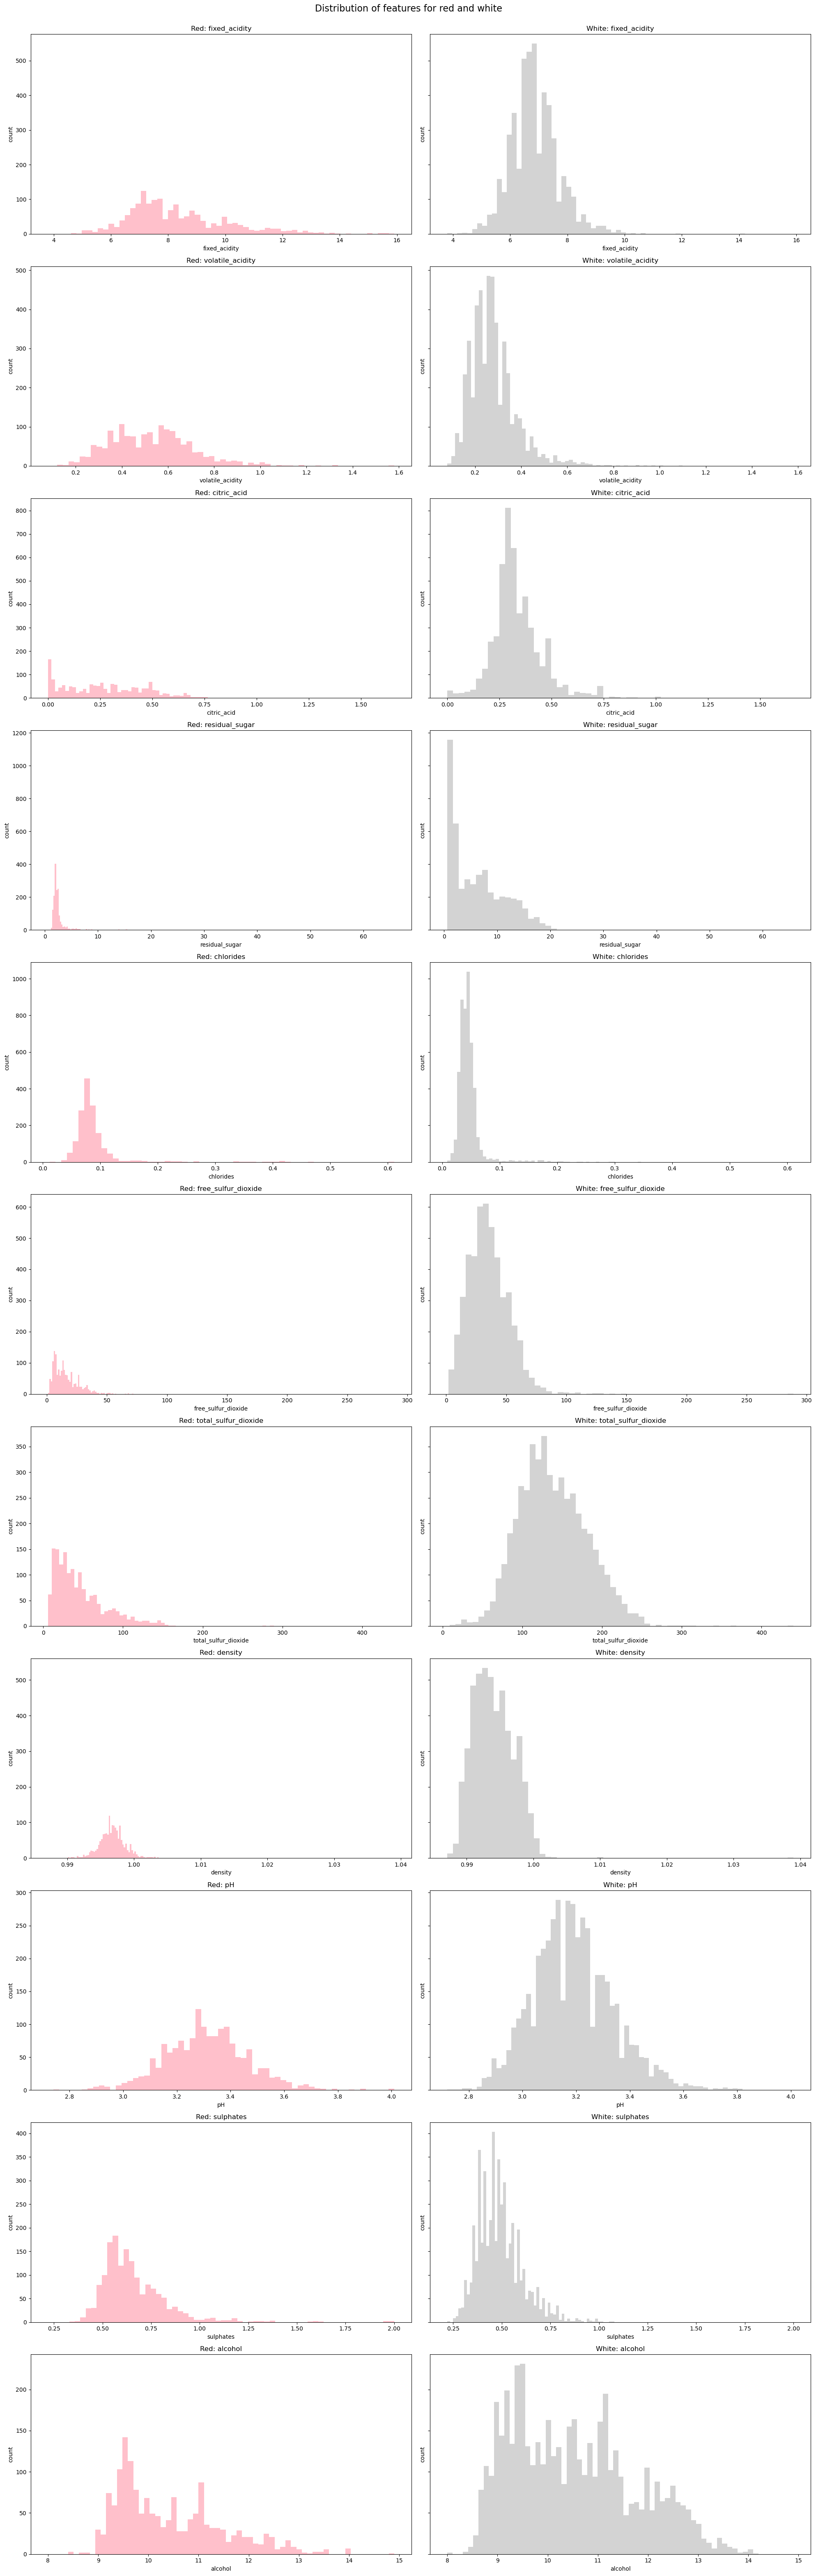

In [10]:
n_bins = 60
fig, axes = plt.subplots(len(columns_to_plot), 2, sharex='row', sharey='row', figsize=(20, 6*len(columns_to_plot)))
for i, col in enumerate(columns_to_plot):
    for j in [0,1]:
        ax = axes[i,j]
        if j == 0:
            ax.hist(df_red[col], bins=n_bins, color='pink')
            ax.set_title(f'Red: {col}')
        else:
            ax.hist(df_white[col], bins=n_bins, color='lightgrey')
            ax.set_title(f'White: {col}')
        
        ax.set_xlabel(col)
        ax.set_ylabel('count')

fig.suptitle('Distribution of features for red and white', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

##### We do see some differences in the features distribution for red and white. Some of the differences may be explained by the difference in the sample sizes of red and white. However, it could also be due to the fact we are considering two different types of wine.

## Boxplot of features per quality score - considering the whole sample

         Number of observations per quality score
quality                                          
3                                              30
4                                             216
5                                            2138
6                                            2836
7                                            1079
8                                             193
9                                               5


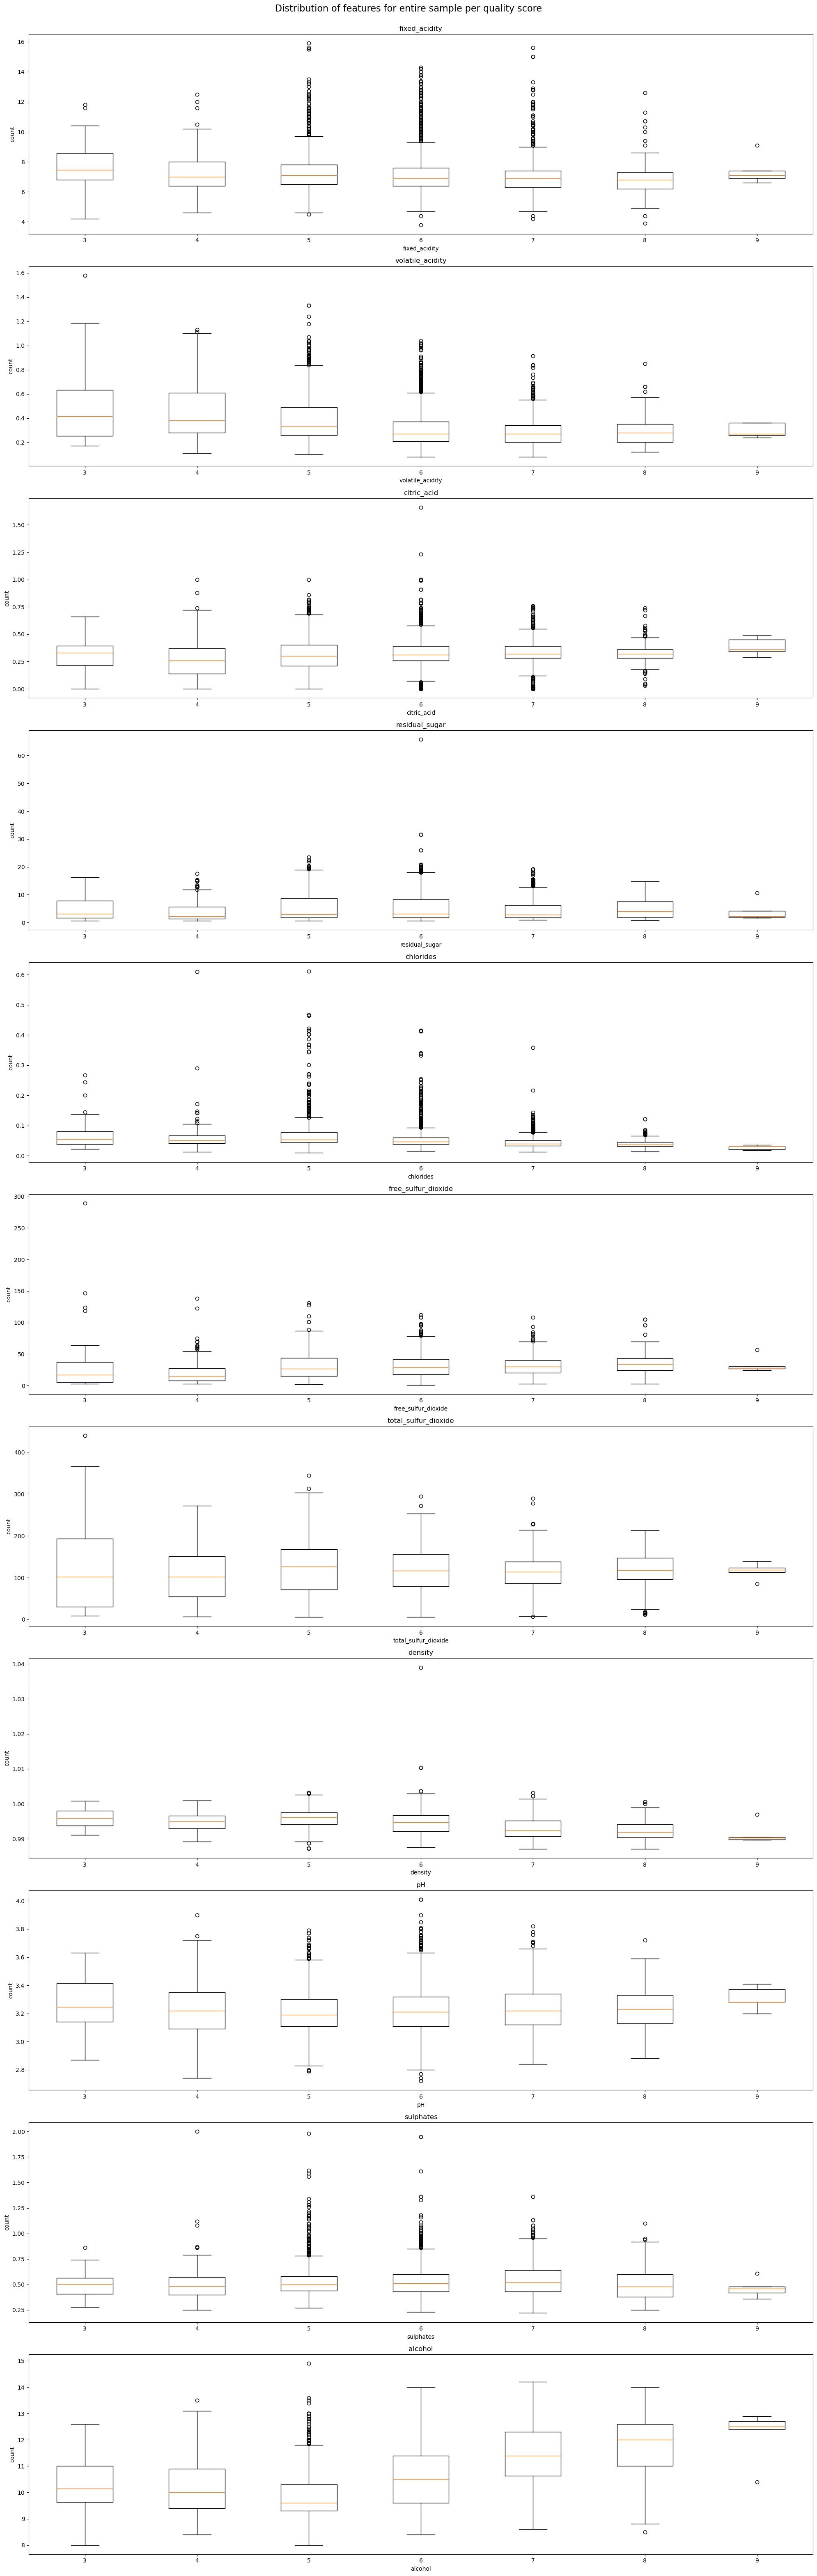

In [11]:
df_wine_count = df_wine.groupby('quality').color.count().rename('Number of observations per quality score').to_frame()
print(df_wine_count)

fig, ax = plt.subplots(len(columns_to_plot), 1, figsize=(20, 6*len(columns_to_plot)))
for i, col in enumerate(columns_to_plot):
    sc3 = df_wine.query('quality == 3')[col]
    sc4 = df_wine.query('quality == 4')[col]
    sc5 = df_wine.query('quality == 5')[col]
    sc6 = df_wine.query('quality == 6')[col]
    sc7 = df_wine.query('quality == 7')[col]
    sc8 = df_wine.query('quality == 8')[col]
    sc9 = df_wine.query('quality == 9')[col]
    
    ax[i].boxplot([sc3, sc4, sc5, sc6, sc7, sc8, sc9], labels=['3', '4', '5', '6', '7', '8', '9'])
    ax[i].set_title(f'{col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('count')

fig.suptitle('Distribution of features for entire sample per quality score', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

##### Above figures shows that the dataset contains outliers.
##### Only for alchohol the interquratile ranges suggest a positive correlation with the quality score.

## Boxplot of features per quality score - split per red and white

         Number of observations per quality score (red)  Number of observations per quality score (white)
quality                                                                                                  
3                                                  10.0                                                20
4                                                  53.0                                               163
5                                                 681.0                                              1457
6                                                 638.0                                              2198
7                                                 199.0                                               880
8                                                  18.0                                               175
9                                                   NaN                                                 5


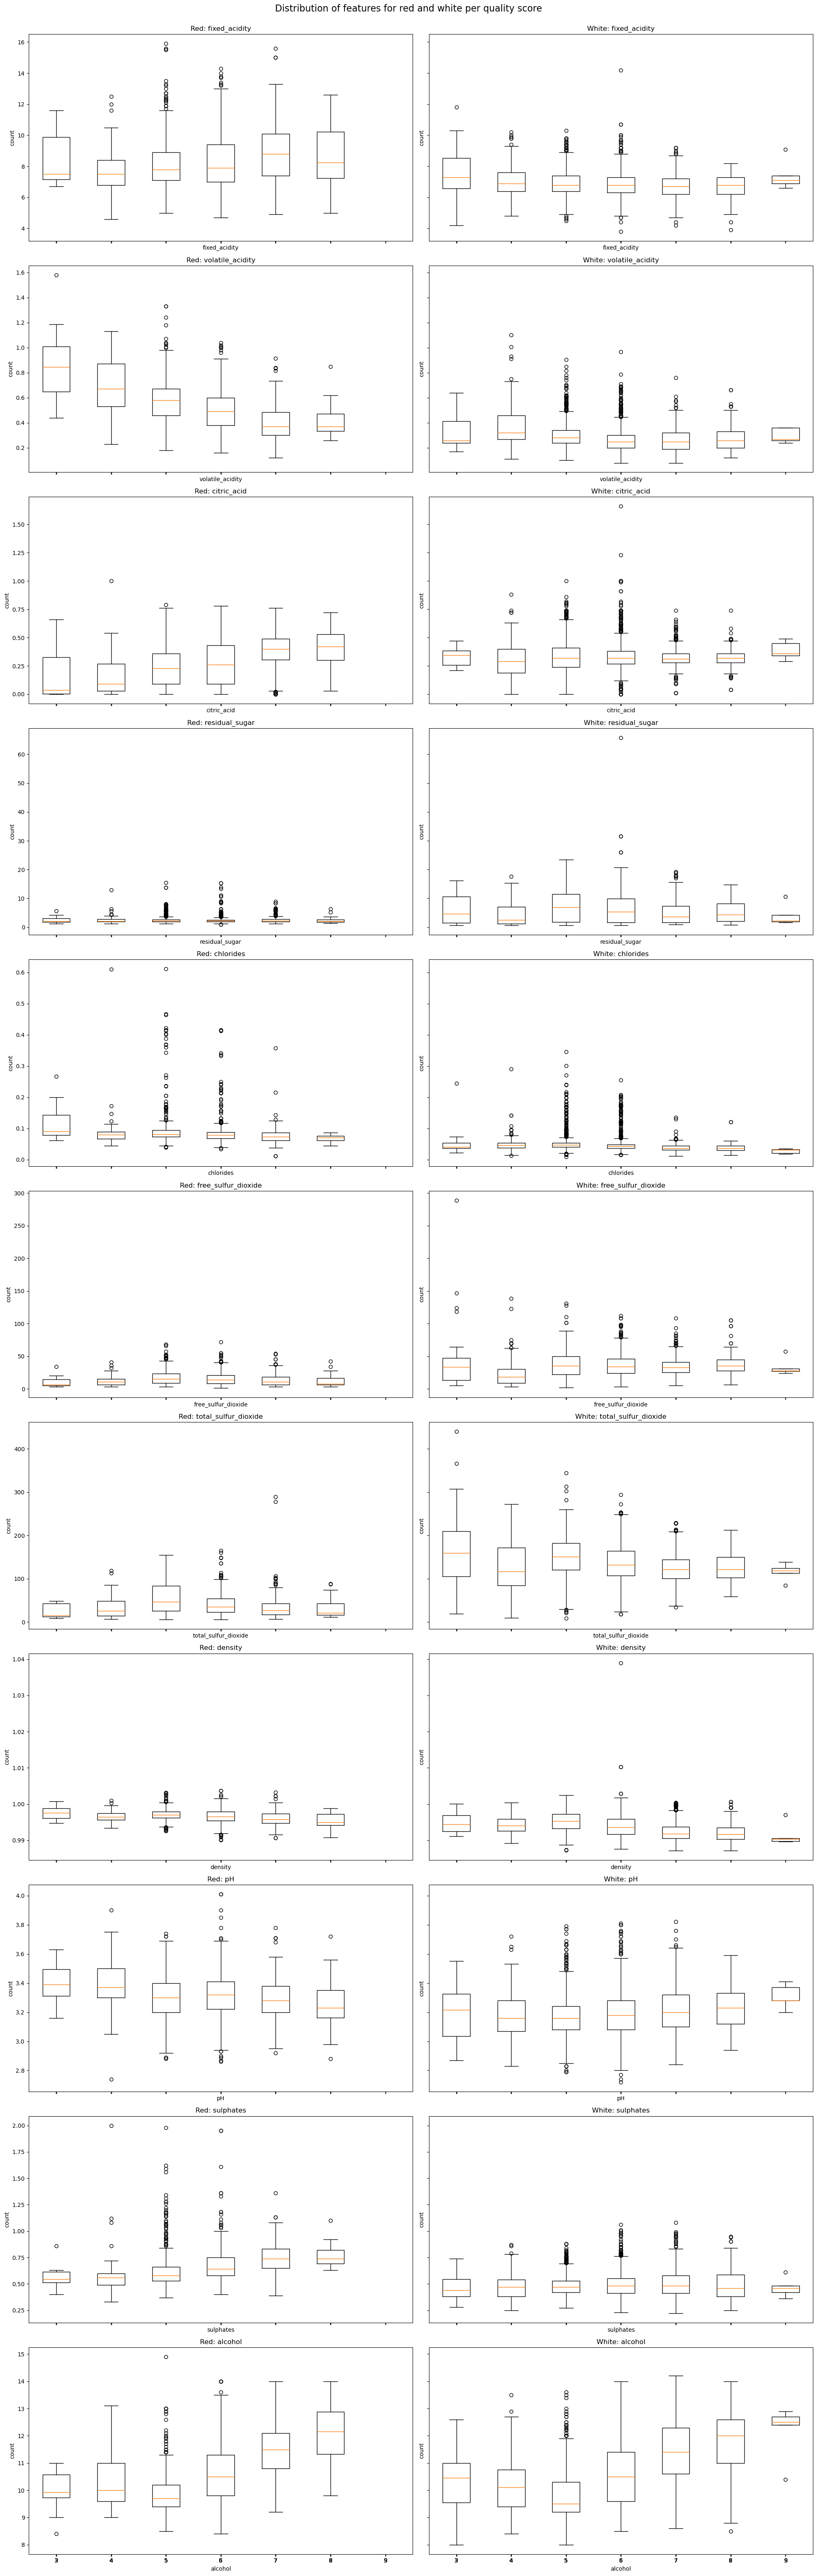

In [12]:
df_red_count = df_red.groupby('quality').color.count().rename('Number of observations per quality score (red)').to_frame()
df_white_count = df_white.groupby('quality').color.count().rename('Number of observations per quality score (white)').to_frame()
df_count = df_white_count.join(df_red_count)
df_count = df_count[['Number of observations per quality score (red)', 'Number of observations per quality score (white)']]
print(df_count)

fig, axes = plt.subplots(len(columns_to_plot), 2, sharex=True, sharey='row', figsize=(20, 6*len(columns_to_plot)))
for i, col in enumerate(columns_to_plot):
    for j in [0,1]:
        red_sc3 = df_red.query('quality == 3')[col]
        red_sc4 = df_red.query('quality == 4')[col]
        red_sc5 = df_red.query('quality == 5')[col]
        red_sc6 = df_red.query('quality == 6')[col]
        red_sc7 = df_red.query('quality == 7')[col]
        red_sc8 = df_red.query('quality == 8')[col]

        white_sc3 = df_white.query('quality == 3')[col]
        white_sc4 = df_white.query('quality == 4')[col]
        white_sc5 = df_white.query('quality == 5')[col]
        white_sc6 = df_white.query('quality == 6')[col]
        white_sc7 = df_white.query('quality == 7')[col]
        white_sc8 = df_white.query('quality == 8')[col]
        white_sc9 = df_white.query('quality == 9')[col]
       
        ax = axes[i,j]
        if j == 0:
            ax.boxplot([red_sc3, red_sc4, red_sc5, red_sc6, red_sc7, red_sc8], labels=['3', '4', '5', '6', '7', '8'])
            ax.set_title(f'Red: {col}')
        else:
            ax.boxplot([white_sc3, white_sc4, white_sc5, white_sc6, white_sc7, white_sc8, white_sc9], labels=['3', '4', '5', '6', '7', '8', '9'])
            ax.set_title(f'White: {col}')

        ax.set_xlabel(col)
        ax.set_ylabel('count')

fig.suptitle('Distribution of features for red and white per quality score', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

##### Again we see outliers for both the red and whites.

#### volatile_acidity:

##### For red the interquartile ranges Q1 and Q3 (25% and 75% quartile) are decreasing, but still overlapping, as the quality score increases. This may indicate a negative correlation with the quality score.
##### For white there is no obvious pattern suggesting any dependencies with the quality score.

#### citric_acid:
##### For red the interquartile range of score 7 and 8 are almost not overlapping with the interquartile range of score 3 and 4. This may indicate a positive correlation between citric_acid and the quality score.
##### For white we do not see the same pattern. Only the interquartile range of quality score 9 looks almost disjoint from the score of 7 and 8. However, with only 5 white wines with a score of 9 it is hard to conclude anything from this.

#### residual_sugar
##### Note the ranges var very different when comparing reds and whites.

#### sulphates:
##### For red we see a pattern similar to citric_acit. This could suggest a positive correlation with the quality score.

#### Alcohol:
##### For both red and white the boxplot could indicate a positve correlation between alcohol and quality score

### Remake boxplot for reds of residual_sugar and free_sulfur_dioxide for identification of outliers.

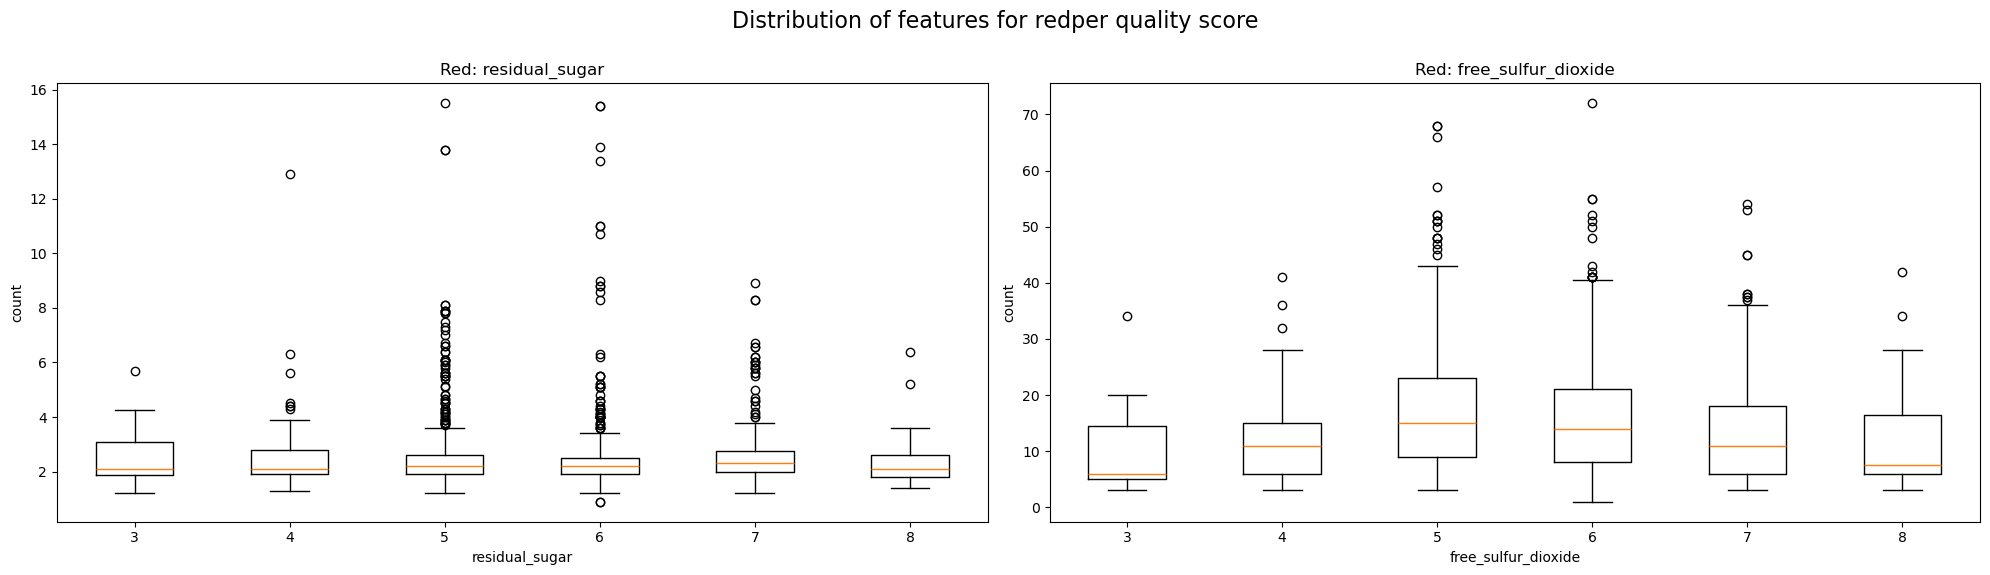

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for i, col in enumerate(['residual_sugar', 'free_sulfur_dioxide']):
    red_sc3 = df_red.query('quality == 3')[col]
    red_sc4 = df_red.query('quality == 4')[col]
    red_sc5 = df_red.query('quality == 5')[col]
    red_sc6 = df_red.query('quality == 6')[col]
    red_sc7 = df_red.query('quality == 7')[col]
    red_sc8 = df_red.query('quality == 8')[col]

    ax = axes[i]
    ax.boxplot([red_sc3, red_sc4, red_sc5, red_sc6, red_sc7, red_sc8], labels=['3', '4', '5', '6', '7', '8'])
    ax.set_title(f'Red: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('count')

fig.suptitle('Distribution of features for redper quality score', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

## Remove extreme outliers - manually

In [14]:
df_red_noOut = df_red.copy()
df_white_noOut = df_white.copy()

In [15]:
df_red_noOut.drop(df_red_noOut.query('fixed_acidity >= 15').index, axis=0, inplace=True)
df_red_noOut.drop(df_red_noOut.query('volatile_acidity >= 1.4').index, axis=0, inplace=True)
df_red_noOut.drop(df_red_noOut.query('citric_acid >= 1').index, axis=0, inplace=True)
df_red_noOut.drop(df_red_noOut.query('chlorides >= 0.55').index, axis=0, inplace=True)
df_red_noOut.drop(df_red_noOut.query('total_sulfur_dioxide >= 220').index, axis=0, inplace=True)
df_red_noOut.drop(df_red_noOut.query('sulphates > 1.75').index, axis=0, inplace=True)
df_red_noOut.drop(df_red_noOut.query('alcohol > 14.8').index, axis=0, inplace=True)
df_red_noOut.drop(df_red_noOut.query('residual_sugar > 12').index, axis=0, inplace=True)
df_red_noOut.drop(df_red_noOut.query('free_sulfur_dioxide > 60').index, axis=0, inplace=True)

df_white_noOut.drop(df_white_noOut.query('fixed_acidity > 14').index, axis=0, inplace=True)
df_white_noOut.drop(df_white_noOut.query('citric_acid > 1.2').index, axis=0, inplace=True)
df_white_noOut.drop(df_white_noOut.query('residual_sugar > 50').index, axis=0, inplace=True)
df_white_noOut.drop(df_white_noOut.query('free_sulfur_dioxide > 250').index, axis=0, inplace=True)
df_white_noOut.drop(df_white_noOut.query('total_sulfur_dioxide > 350').index, axis=0, inplace=True)
df_white_noOut.drop(df_white_noOut.query('density > 1.03').index, axis=0, inplace=True)

### Concate the red and white dataframes without outliers

In [16]:
df_wine_noOut = pd.concat([df_red_noOut, df_white_noOut]).sort_index()
print('Total removed datapoints: ', df_wine.shape[0] - df_wine_noOut.shape[0])

Total removed datapoints:  32


## In the following consider data without outliers

## Correlations

In [17]:
print('Correlations considering the whole sample:')
corr = df_wine_noOut.drop(columns=['color']).corr()
mask = np.zeros_like(corr, dtype=bool) # Fill diagonal and upper half with NaNs
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
corr.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).highlight_null(color='#f1f1f1').format(precision=2)

Correlations considering the whole sample:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
volatile_acidity,0.22,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
citric_acid,0.32,-0.39,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
residual_sugar,-0.12,-0.21,0.14,nan,nan,nan,nan,nan,nan,nan,nan,nan
chlorides,0.30,0.39,0.02,-0.14,nan,nan,nan,nan,nan,nan,nan,nan
free_sulfur_dioxide,-0.29,-0.36,0.14,0.42,-0.21,nan,nan,nan,nan,nan,nan,nan
total_sulfur_dioxide,-0.33,-0.42,0.20,0.50,-0.29,0.72,nan,nan,nan,nan,nan,nan
density,0.46,0.26,0.09,0.54,0.37,0.03,0.04,nan,nan,nan,nan,nan
pH,-0.25,0.26,-0.33,-0.28,0.06,-0.16,-0.24,0.01,nan,nan,nan,nan
sulphates,0.30,0.23,0.05,-0.19,0.38,-0.20,-0.28,0.26,0.22,nan,nan,nan


##### Considering the whole sample the quality score is positively correlated with alcohol and negatively correlated with density, volatile_acidity and chlorides.
##### Note, we also see som higher correlation between the different features.

In [18]:
print('Correlations considering the reds:')
corr = df_red_noOut.drop(columns=['color']).corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
corr.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).highlight_null(color='#f1f1f1').format(precision=2)

Correlations considering the reds:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
volatile_acidity,-0.27,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
citric_acid,0.69,-0.56,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
residual_sugar,0.13,0.04,0.12,nan,nan,nan,nan,nan,nan,nan,nan,nan
chlorides,0.10,0.06,0.18,0.00,nan,nan,nan,nan,nan,nan,nan,nan
free_sulfur_dioxide,-0.16,-0.01,-0.07,0.07,-0.04,nan,nan,nan,nan,nan,nan,nan
total_sulfur_dioxide,-0.11,0.10,0.01,0.13,0.04,0.67,nan,nan,nan,nan,nan,nan
density,0.67,0.02,0.37,0.35,0.19,-0.06,0.08,nan,nan,nan,nan,nan
pH,-0.68,0.23,-0.53,-0.06,-0.25,0.09,-0.04,-0.33,nan,nan,nan,nan
sulphates,0.18,-0.28,0.32,0.02,0.34,0.05,0.01,0.14,-0.15,nan,nan,nan


##### Considering the reds the quality score is positively correlated with alcohol, sulphates and citric_acid and negatively correlated with volatile_acidity. This was also what the boxplots above for red indicated. We also see a negative correlation with total_sulfur_dioxide.
##### Again, we see som higher correlations between features.

In [19]:
print('Correlations considering the whites:')
corr = df_white_noOut.drop(columns=['color']).corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
corr.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).highlight_null(color='#f1f1f1').format(precision=2)

Correlations considering the whites:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
volatile_acidity,-0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
citric_acid,0.29,-0.15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
residual_sugar,0.09,0.05,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan
chlorides,0.02,0.07,0.12,0.09,nan,nan,nan,nan,nan,nan,nan,nan
free_sulfur_dioxide,-0.05,-0.10,0.10,0.32,0.10,nan,nan,nan,nan,nan,nan,nan
total_sulfur_dioxide,0.09,0.09,0.12,0.41,0.20,0.61,nan,nan,nan,nan,nan,nan
density,0.27,0.01,0.15,0.83,0.26,0.31,0.55,nan,nan,nan,nan,nan
pH,-0.43,-0.03,-0.17,-0.20,-0.09,-0.01,0.00,-0.10,nan,nan,nan,nan
sulphates,-0.02,-0.04,0.06,-0.03,0.02,0.06,0.13,0.07,0.16,nan,nan,nan


##### Considering the whites the quality score is positively correlated with alcohol (as indicated by above boxplots) and negatively correlated with density, chlorides and volatile_acidity.
##### Again, we see som higher correlations between features. Some correlations of features are stronger/weaker compared to the feature correlations of the reds.

## Sumup

- The majority of samples are white (75%)
- The quality score is imbalance for both the red and whites, meaning there are large differences in the number of samples with a given quality score
- The sample only contains quality score of 3-9.
- The data contains outliers which has been manually identified and removed
- The distribution of features varies, some resembles (right skewed) normal distributions
- For some of the features the distribution could be different or shifted (having another mean) when comparing red and white
- The ranges of residual_sugar for the reds are much smaller than for the whites
- Considering the whole dataset the quality score is positively correlated with alcohol and negatively correlated with density, volatile_acidity and chlorides. Some features has high correlations.
- Reds are positively correlated with alcohol, sulphates and citric_acid and negatively correlated with volatile_acidity. Some features has high correlations.
- Whites are positively correlated with alcohol and negatively correlated with density, chlorides and volatile_acidity. Some features has high correlations.
- The size of the feature correlations varies depending on whether we are considering the whole dataset, reds, or whites.

The correlations may suggest that, besides from alcohol, different features are import for the quality score depending on whether it is a red or white.

## Data preparation

### Merge quality scores

##### Due to few observations in red and white for the lower and higher quality scores we aggregate them into the same quality score.
##### Doing this aggregation does not change the fact that the data is imbalanced.

In [20]:
df_wine_5cat = df_wine_noOut.copy()
df_wine_5cat.loc[df_wine_5cat['quality'] == 3, 'quality'] = 4
df_wine_5cat.loc[df_wine_5cat['quality'] == 9, 'quality'] = 8

# make color binary
df_wine_5cat['color_bin'] = 0  # red
df_wine_5cat.loc[df_wine_5cat['color'] == 'white', 'color_bin'] = 1  # white
df_wine_5cat = df_wine_5cat.drop('color', axis=1)

# update red and white
df_red_5cat = df_wine_5cat.query('color_bin == 0')
df_white_5cat = df_wine_5cat.query('color_bin == 1')

In [21]:
df_red_5cat_count = df_red_5cat.groupby('quality').color_bin.count().rename('Number of observations per quality score (red)').to_frame()
df_white_5cat_count = df_white_5cat.groupby('quality').color_bin.count().rename('Number of observations per quality score (white)').to_frame()
df_5cat_count = df_white_5cat_count.join(df_red_5cat_count)
df_5cat_count = df_5cat_count[['Number of observations per quality score (red)', 'Number of observations per quality score (white)']]
print(df_5cat_count)

         Number of observations per quality score (red)  Number of observations per quality score (white)
quality                                                                                                  
4                                                    60                                               181
5                                                   669                                              1457
6                                                   632                                              2194
7                                                   194                                               880
8                                                    18                                               180


## Model Fitting

##### Due to the small sample size we not split the train data into train and validation. Instead, we use OOB score as substitute for validation set. Further, we split using stratification due to imbalanced data.

In [22]:
x_wine = df_wine_5cat.drop(['quality', 'color_bin'], axis=1)  # the color is not considered a feature from the data provider
y_wine = df_wine_5cat.quality

X_train, X_test, y_train, y_test = train_test_split(x_wine, y_wine, test_size=0.2, stratify=y_wine, random_state=42)

print("Class distribution in training set:", {i: sum(y_train == i) for i in sorted(y_wine.unique())})
print("Class distribution in test set:", {i: sum(y_test == i) for i in sorted(y_wine.unique())})

Class distribution in training set: {4: 193, 5: 1701, 6: 2261, 7: 859, 8: 158}
Class distribution in test set: {4: 48, 5: 425, 6: 565, 7: 215, 8: 40}


### Model1: Random forest classifier (rfc)

##### Since we are considering an imbalanced dataset we consider the f1_macro scoring instead of accuracy. Also for cross validation we use StratifiedKFold to account for imbalance
##### Since we are considering a small dataset n_estimators and max_depth should not be choosen too high as this can result in overfitting.

In [23]:
param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt'],
    'bootstrap': [True, False],
    'oob_score': [True]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
gscv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
gscv.fit(X_train, y_train)

print('\nBest grid parameters: ', gscv.best_params_)
print('\noob of best params: ', rfc_get_best_oob_score(gscv.best_params_, X_train, y_train))
print('score train set:    ', gscv.score(X_train, y_train))
print('score test set:     ', gscv.score(X_test, y_test))

print('\nClassification report:')
y_pred = gscv.predict(X_test)
print(metrics.classification_report(y_test, y_pred))


Best grid parameters:  {'bootstrap': True, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50, 'oob_score': True}

oob of best params:  0.5815931941221965
score train set:     0.41165857059981936
score test set:      0.32190433422052456

Classification report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00        48
           5       0.65      0.64      0.65       425
           6       0.55      0.75      0.63       565
           7       0.51      0.24      0.33       215
           8       0.00      0.00      0.00        40

    accuracy                           0.58      1293
   macro avg       0.34      0.33      0.32      1293
weighted avg       0.54      0.58      0.54      1293



##### The train-test gap=9% is a bit high. oob-test gab = 26%. This model may not generalize well to new data (overfitting)

**Definitions**

**accuracy** = proportion of correctly classified instances out of all instances, both true positives and true negatives

**macro avg** = useful when you want to evaluate the model's performance across all classes equally (equal weight to each class, regardless of its frequency in the dataset)

**weighted avg** = useful when you want to evaluate the model's performance while taking class imbalance into account (more weight to classes with more instances, reflecting their importance in the dataset)


##### accuracy may not be suitable for imbalanced datasets, since accuracy may be high because the model predicts the majority class most of the time, while performing poorly on minority classes.

##### Note, we could consider the macro_avg if we aim to increase model performance on classes with few instances.

##### Useful metrics for model optimization since quality score is imbalanced
###### false positive = model predicted positive but it was negative
###### false negative = model predicted a negative but it was positive

###### Precision = true positives / (true positives + false positive) = measure of accuracy of positive predictions for a class (model's ability to avoid false positives)
###### Recall = true positives / (true positives + false negatives) = measures the ability of the model to find all positive instances of a class
###### f1-score = harmonic mean of precision and recall (which punishes extreme values)
###### There is a tradeoff between Precision and Recall, when one increases the other decreases and vice versa.

###### As example consider the quality score of 8:
###### Recall equals 1 if the model can correctly identify all 40 test samples with a quality score of 8. However, this means that the precision would be low, meaning the model would predict many false positive, i.e. it would predict many test samples (>>40) with a lower quality score to have a quality score of 8.

##### Below are saved a few of the grid searches in trying to get a better model

In [57]:
# param_grid = {
#     'n_estimators': [50, 75, 100],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 3, 5],
#     'min_samples_leaf': [1, 2, 3],
#     'max_features': ['sqrt'],
#     'bootstrap': [True, False],
#     'oob_score': [True]
# }

# # altered: train-test gap = 2.8%, macro avg = 0.3
# param_grid = {
#     'n_estimators': [50, 75, 100],
#     'max_depth': [3, 5],
#     'min_samples_split': [3, 5],
#     'min_samples_leaf': [1, 2, 3],
#     'max_features': ['sqrt'],
#     'bootstrap': [True, False],
#     # 'max_samples': [1500, 2500],
#     'oob_score': [True]
# }
# altered2: train-test gap = 2.2%, macro avg = 30
param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt'],
    'bootstrap': [True, False],
    # 'max_samples': [1500, 2500],
    'oob_score': [True]
}
# # altered3: train-test gap = 2.5%, macro avg = 0.28
# param_grid = {
#     'n_estimators': [50, 75, 100],
#     'max_depth': [3, 5],
#     'min_samples_split': [2, 3],
#     'min_samples_leaf': [1, 2, 3],
#     'max_features': ['sqrt'],
#     'bootstrap': [True],
#     'max_samples': [1500, 2500],
#     'oob_score': [True]
# }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
gscv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
gscv.fit(X_train, y_train)

print('\nBest grid parameters: ', gscv.best_params_)
print('\noob of best params: ', rfc_get_best_oob_score(gscv.best_params_, X_train, y_train))
print('score train set:    ', gscv.score(X_train, y_train))
print('score test set:     ', gscv.score(X_test, y_test))

print('\nClassification report:')
y_pred = gscv.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

print('\nFeature importance:')
feature_importance_dict = dict(zip(X_train.columns, gscv.best_estimator_.feature_importances_))
for feature, importance in feature_importance_dict.items():
    print(f"{feature:<20}: {importance:.4f}")


Best grid parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 75, 'oob_score': True}

oob of best params:  0.5603248259860789
score train set:     0.3233446214361563
score test set:      0.30124894532593094

Classification report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00        48
           5       0.65      0.62      0.64       425
           6       0.53      0.77      0.63       565
           7       0.53      0.16      0.24       215
           8       0.00      0.00      0.00        40

    accuracy                           0.57      1293
   macro avg       0.34      0.31      0.30      1293
weighted avg       0.53      0.57      0.52      1293


Feature importance:
fixed_acidity       : 0.0264
volatile_acidity    : 0.1439
citric_acid         : 0.0480
residual_sugar      : 0.0486
chlorides           : 0.0802
free_sulfur_dioxide : 0.0449


##### We lowered the train-test gap to 2.2%. However oob-test gap=26% is still high. macro avg = 30 (compared to 32 in previous model). Since this model has a lower train-test gap let continue based on this.

## Try dropping features

##### Considering the feature importances above and the correlation matrix further above, lets try dropping features and implementing new features (would have used a pipeline but could not get it to work).

##### Consider above model with macro avg = 30:

Summary of runs below:

(A) train-test gap = 2.4%, oob-test gab=26.2%, macro avg = 30

(B) train-test gap = 1.9%, oob-test gab=25.5%, macro avg = 30

(C) train-test gap = 1.8%, oob-test gab=25%, macro avg = 30

(D) train-test gap = 2.8%, oob-test gab=27%, macro avg = 28

None of these show any improvements. Next, let's try adding features

In [70]:
# drop_features_idx = [0]  # (A) features with importance < 0.03
# drop_features_idx = [0, 8]  # (B) features with importance < 0.04
# drop_features_idx = [0, 2, 3, 5, 6, 8, 9]  # (C) features with importance < 0.05
drop_features_idx = [6, 7]  # (D) drop total_sulfur_dioxide and density which has corr > 0.7 with another feature

X_train_dropFea = X_train.drop(X_train.columns[drop_features_idx], axis=1)
X_test_dropFea = X_test.drop(X_train.columns[drop_features_idx], axis=1)

In [71]:
X_train_input = X_train_dropFea.copy()
X_test_input = X_test_dropFea.copy()

param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt'],
    'bootstrap': [True, False],
    # 'max_samples': [1500, 2500],
    'oob_score': [True]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
gscv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
gscv.fit(X_train_input, y_train)

print('\nBest grid parameters: ', gscv.best_params_)
print('\noob of best params: ', rfc_get_best_oob_score(gscv.best_params_, X_train_input, y_train))
print('score train set:    ', gscv.score(X_train_input, y_train))
print('score test set:     ', gscv.score(X_test_input, y_test))

print('\nClassification report:')
y_pred = gscv.predict(X_test_input)
print(metrics.classification_report(y_test, y_pred))

print('\nFeature importance:')
print(gscv.best_estimator_.feature_importances_)


Best grid parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}

oob of best params:  0.5551044083526682
score train set:     0.3112568161877479
score test set:      0.28324562758069416

Classification report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00        48
           5       0.64      0.61      0.62       425
           6       0.52      0.78      0.62       565
           7       0.51      0.10      0.17       215
           8       0.00      0.00      0.00        40

    accuracy                           0.56      1293
   macro avg       0.33      0.30      0.28      1293
weighted avg       0.52      0.56      0.51      1293


Feature importance:
[0.03670127 0.17776343 0.06103629 0.04749959 0.11807112 0.05227403
 0.04342809 0.05974405 0.40348212]


## Try adding features

##### From the dataanalysis we found that some features behaved differently for red and white compared to the quality score (the boxplots). Also from the correlation matrices for red and white we see different correlations between features and correlations with quality.
##### Let's try adding some features based on this.

In [73]:
df_wine_5cat_addFea = df_wine_5cat.copy()
df_wine_5cat_addFea['red'] = df_wine_5cat.color_bin.apply(lambda x: 1 if x == 0 else 0)
df_wine_5cat_addFea['white'] = df_wine_5cat.color_bin.apply(lambda x: 1 if x == 1 else 0)
df_wine_5cat_addFea['sulfur_div'] = df_wine_5cat_addFea.total_sulfur_dioxide / df_wine_5cat_addFea.free_sulfur_dioxide
df_wine_5cat_addFea['residual_sugar_times_density'] = df_wine_5cat_addFea.residual_sugar * df_wine_5cat_addFea.density
df_wine_5cat_addFea['density_times_alcohol'] = df_wine_5cat_addFea.density * df_wine_5cat_addFea.alcohol

x_wine_addFea = df_wine_5cat_addFea.drop(['quality', 'color_bin'], axis=1)
y_wine_addFea = df_wine_5cat_addFea.quality
X_train_addFea, X_test_addFea, y_train_addFea, y_test_addFea = train_test_split(x_wine_addFea, y_wine_addFea, test_size=0.2, stratify=y_wine_addFea,
                                                                                random_state=42)

In [76]:
X_train_input = X_train_addFea.copy()
X_test_input = X_test_addFea.copy()

param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt'],
    'bootstrap': [True, False],
    # 'max_samples': [1500, 2500],
    'oob_score': [True]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
gscv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
gscv.fit(X_train_input, y_train)

print('\nBest grid parameters: ', gscv.best_params_)
print('\noob of best params: ', rfc_get_best_oob_score(gscv.best_params_, X_train_input, y_train))
print('score train set:    ', gscv.score(X_train_input, y_train))
print('score test set:     ', gscv.score(X_test_input, y_test))

print('\nClassification report:')
y_pred = gscv.predict(X_test_input)
print(metrics.classification_report(y_test, y_pred))


print('\nFeature importance:')
feature_importance_dict = dict(zip(X_train_input.columns, gscv.best_estimator_.feature_importances_))
for feature, importance in feature_importance_dict.items():
    print(f"{feature:<20}: {importance:.4f}")


Best grid parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'oob_score': True}

oob of best params:  0.5607115235885538
score train set:     0.326867399367833
score test set:      0.30576170515502243

Classification report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00        48
           5       0.64      0.62      0.63       425
           6       0.53      0.75      0.62       565
           7       0.53      0.19      0.28       215
           8       0.00      0.00      0.00        40

    accuracy                           0.56      1293
   macro avg       0.34      0.31      0.31      1293
weighted avg       0.53      0.56      0.52      1293


Feature importance:
fixed_acidity       : 0.0170
volatile_acidity    : 0.1533
citric_acid         : 0.0359
residual_sugar      : 0.0238
chlorides           : 0.0502
free_sulfur_dioxide : 0.0318
t

##### train-test gap = 2.1%, oob-test gab=25.5%, macro avg = 31. The numbers are better than the model we are comparing to (train-test gap=2.2%, oob-test gap=26%, macro avg=30), but insignificantly better.
##### However oob-test gap still suggest model generalises poorly to new data (high variance). From the recall score we also see how the model cannot perform on classes with few instances.

##### Some of the added features has very low feature importance. Let's try removing some and reducing the model complexity. This is done below and here is a summary of the runs:

(A) train-test gap=2.2%, oob-test gab=25.8%, macro avg = 30

(B) train-test gap=3%, oob-test gab=26%, macro avg = 29

(C) train-test gap=1.5%, oob-test gab=26.8%, macro avg = 29

No improment seen by trying to remove any features after having added new ones.

##### Let's keep the added features for now and see if a Gradient Boosting Classification can fit a better model. Since we are considering a small dataset with few features I do not mind the small addition of complexity by the added features.

In [84]:
X_train_addFea_dropFea = X_train_addFea.copy()
X_test_addFea_dropFea = X_test_addFea.copy()

# Drop features after having added features
drop_cols = ['red', 'white']  # (A)
# drop_cols = ['fixed_acidity', 'red', 'white']  # (B)
# drop_cols = ['free_sulfur_dioxide', 'total_sulfur_dioxide', 'residual_sugar', 'density', 'alcohol']  # (C) features included in engineered features

X_train_addFea_dropFea = X_train_addFea_dropFea.drop(drop_cols, axis=1)
X_test_addFea_dropFea = X_test_addFea_dropFea.drop(drop_cols, axis=1)

In [91]:
X_train_input = X_train_addFea_dropFea.copy()
X_test_input = X_test_addFea_dropFea.copy()

param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt'],
    'bootstrap': [True, False],
    # 'max_samples': [1500, 2500],
    'oob_score': [True]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
gscv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
gscv.fit(X_train_input, y_train)

print('\nBest grid parameters: ', gscv.best_params_)
print('\noob of best params: ', rfc_get_best_oob_score(gscv.best_params_, X_train_input, y_train))
print('score train set:    ', gscv.score(X_train_input, y_train))
print('score test set:     ', gscv.score(X_test_input, y_test))

print('\nClassification report:')
y_pred = gscv.predict(X_test_input)
print(metrics.classification_report(y_test, y_pred))


Best grid parameters:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50, 'oob_score': True}

oob of best params:  0.5587780355761794
score train set:     0.3220463636491583
score test set:      0.3007081873197406

Classification report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00        48
           5       0.64      0.62      0.63       425
           6       0.53      0.76      0.62       565
           7       0.50      0.17      0.25       215
           8       0.00      0.00      0.00        40

    accuracy                           0.56      1293
   macro avg       0.33      0.31      0.30      1293
weighted avg       0.52      0.56      0.52      1293



### Model2: Gradient Boosting classifier (gbc)

In [90]:
X_train_input = X_train_addFea.copy()
X_test_input = X_test_addFea.copy()

param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.02, 0.05],
    'max_depth': [1, 2],  # use weak learners/stumps
    'min_samples_split': [5, 7],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'n_iter_no_change': [10],
    'validation_fraction': [0.1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
gscv = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
gscv.fit(X_train_input, y_train)

print('\nBest grid parameters: ', gscv.best_params_)
get_n_estimators = GradientBoostingClassifier(**gscv.best_params_, random_state=42)
get_n_estimators.fit(X_train_input, y_train)
print('\nn_estimators of best parameters:', get_n_estimators.n_estimators_)

print('\nscore train set:    ', gscv.score(X_train_input, y_train))
print('score test set:     ', gscv.score(X_test_input, y_test))

print('\nClassification report:')
y_pred = gscv.predict(X_test_input)
print(metrics.classification_report(y_test, y_pred))


Best grid parameters:  {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 500, 'n_iter_no_change': 10, 'subsample': 1.0, 'validation_fraction': 0.1}

n_estimators of best parameters: 398

score train set:     0.5807457411016094
score test set:      0.44414367775750846

Classification report:
              precision    recall  f1-score   support

           4       0.53      0.19      0.28        48
           5       0.65      0.62      0.63       425
           6       0.56      0.73      0.63       565
           7       0.53      0.32      0.40       215
           8       0.70      0.17      0.28        40

    accuracy                           0.59      1293
   macro avg       0.59      0.41      0.44      1293
weighted avg       0.59      0.59      0.57      1293


Best parameters: {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 500, 'n_iter_no_change': 10, 'subsample': 1.

##### train-test gap = 13.5%, macro avg = 44. With these initial grid parameters we seem to be overfitting. Let's try and change the grid parameter settings below,

### Below we have explored different grid parameter settings (A) - (E):
##### Having constrained the gbc model enough we avoided overfitting and optained a train-test gap=5.7%, macro avg=32. As seen in below output the model still performs best on quality classes with majority of instances.
##### The f1-score of
- class 5 is 0.02 lower compared to the best rfc above
- class 6-7 are the same as the rfc
- class 4 and 8 now have a f1-score > 0, which was 0 in the rfc.

Thus the gbc beats the rfc, although it is still not a high performing model.

In [106]:
X_train_input = X_train_addFea.copy()
X_test_input = X_test_addFea.copy()

# # (A) train-test gap=13.9%, macro avg=45
# param_grid = {
#     'n_estimators': [300, 500],
#     'learning_rate': [0.02, 0.05],
#     'max_depth': [1, 2],  # use weak learners/stumps
#     'min_samples_split': [3, 5],
#     'min_samples_leaf': [1, 2],
#     'subsample': [0.8, 1.0],
#     'n_iter_no_change': [10],
#     'validation_fraction': [0.1]
# }

# # (B) train-test gap=9.9%, macro avg=43
# param_grid = {
#     'n_estimators': [200, 300],
#     'learning_rate': [0.02, 0.05],
#     'max_depth': [1, 2],  # use weak learners/stumps
#     'min_samples_split': [5, 7],
#     'min_samples_leaf': [1, 2],
#     'subsample': [0.8, 1.0],
#     'n_iter_no_change': [10],
#     'validation_fraction': [0.1]
# }

# # (C) train-test gap=8.4%, macro avg=33  --> getting closer
# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.02],
#     'max_depth': [1, 2],  # use weak learners/stumps
#     'min_samples_split': [5, 7],
#     'min_samples_leaf': [1, 2],
#     'subsample': [0.8, 1.0],
#     'n_iter_no_change': [10],
#     'validation_fraction': [0.1]
# }

# (D) train-test gap=5.7%, macro avg=32  --> getting even closer
param_grid = {
    'n_estimators': [75, 150],
    'learning_rate': [0.01, 0.02],
    'max_depth': [1, 2],  # use weak learners/stumps
    'min_samples_split': [3, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'n_iter_no_change': [10],
    'validation_fraction': [0.1]
}

# # (E) train-test gap=5%, macro avg=30  --> getting closer
# param_grid = {
#     'n_estimators': [75, 100],
#     'learning_rate': [0.01, 0.02],
#     'max_depth': [1, 2],  # use weak learners/stumps
#     'min_samples_split': [3, 5],
#     'min_samples_leaf': [1, 2],
#     'subsample': [0.8, 1.0],
#     'n_iter_no_change': [10],
#     'validation_fraction': [0.1]
# }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
gscv = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
gscv.fit(X_train_input, y_train)

print('\nBest grid parameters: ', gscv.best_params_)
get_n_estimators = GradientBoostingClassifier(**gscv.best_params_, random_state=42)
get_n_estimators.fit(X_train_input, y_train)
print('\nn_estimators of best parameters:', get_n_estimators.n_estimators_)

print('\nscore train set:    ', gscv.score(X_train_input, y_train))
print('score test set:     ', gscv.score(X_test_input, y_test))

print('\nClassification report:')
y_pred = gscv.predict(X_test_input)
print(metrics.classification_report(y_test, y_pred))

gbc = GradientBoostingClassifier(**gscv.best_params_, random_state=42)
gbc.fit(X_train_input, y_train)
feature_importances = gbc.feature_importances_
cols = X_train_input.columns
print("\nFeature Importances:")
for feature_name, importance in zip(cols, feature_importances):
    print(f"{feature_name:<20}: {importance:.4f}")


Best grid parameters:  {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150, 'n_iter_no_change': 10, 'subsample': 0.8, 'validation_fraction': 0.1}

n_estimators of best parameters: 150

score train set:     0.3805713722696938
score test set:      0.32327917232590503

Classification report:
              precision    recall  f1-score   support

           4       0.27      0.06      0.10        48
           5       0.63      0.60      0.61       425
           6       0.53      0.74      0.62       565
           7       0.47      0.20      0.28       215
           8       0.00      0.00      0.00        40

    accuracy                           0.55      1293
   macro avg       0.38      0.32      0.32      1293
weighted avg       0.53      0.55      0.52      1293


Feature Importances:
fixed_acidity       : 0.0063
volatile_acidity    : 0.2191
citric_acid         : 0.0173
residual_sugar      : 0.0077
chlorides           : 0.029

#### Try removing features based on above param_grid and feature importances

##### Below we run different cases of removing insignificant features, here is a summary:

(A) train-test gap=5.3%, macro avg=0.32

(B) train-test gap=5.6%, macro avg=0.32

(C) train-test gap=3.3%, macro avg=0.32 (only keeping features: volatile_acidity, sulfur_div, density_times_alcohol)
f1-score for class
4  0.10
5  0.61
6  0.62
7  0.28
8  0.00

(D) train-test gap=2.5%, macro avg=031 (only keeping features: volatile_acidity, density_times_alcohol)
f1-score for class
4  0.04
5  0.60
6  0.61
7  0.28
8  0.00

(C) results in the best model (no further fine tuning of the parameter grid is done - one could have repeated this step)

Only keeping the 3 features: volatile_acidity, sulfur_div, density_times_alcohol, results in the best model. However, above f1-scores shows that, despite this being the best model we have come up with, it still does not perform well.

In [118]:
X_train_addFea_dropFea = X_train_addFea.copy()
X_test_addFea_dropFea = X_test_addFea.copy()

# Drop features after having added features
# drop_cols = ['red', 'white']  # (A) feature importance < 0.05
# drop_cols = ['fixed_acidity', 'residual_sugar', 'total_sulfur_dioxide', 'red', 'white']  # (B) feature importance < 0.01
drop_cols = ['fixed_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide',
             'density', 'pH', 'sulphates', 'alcohol', 'red', 'white', 'residual_sugar_times_density']  # (C) feature importance < 0.05
# drop_cols = ['fixed_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide',
#              'density', 'pH', 'sulphates', 'alcohol', 'red', 'white', 'sulfur_div', 'residual_sugar_times_density']  # (D) feature importance < 0.1

X_train_addFea_dropFea = X_train_addFea_dropFea.drop(drop_cols, axis=1)
X_test_addFea_dropFea = X_test_addFea_dropFea.drop(drop_cols, axis=1)

In [119]:
X_train_input = X_train_addFea_dropFea.copy()
X_test_input = X_test_addFea_dropFea.copy()

# (D) 
param_grid = {
    'n_estimators': [75, 150],
    'learning_rate': [0.01, 0.02],
    'max_depth': [1, 2],  # use weak learners/stumps
    'min_samples_split': [3, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'n_iter_no_change': [10],
    'validation_fraction': [0.1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
gscv = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
gscv.fit(X_train_input, y_train)

print('\nBest grid parameters: ', gscv.best_params_)
get_n_estimators = GradientBoostingClassifier(**gscv.best_params_, random_state=42)
get_n_estimators.fit(X_train_input, y_train)
print('\nn_estimators of best parameters:', get_n_estimators.n_estimators_)

print('\nscore train set:    ', gscv.score(X_train_input, y_train))
print('score test set:     ', gscv.score(X_test_input, y_test))

print('\nClassification report:')
y_pred = gscv.predict(X_test_input)
print(metrics.classification_report(y_test, y_pred))

gbc = GradientBoostingClassifier(**gscv.best_params_, random_state=42)
gbc.fit(X_train_input, y_train)
feature_importances = gbc.feature_importances_
cols = X_train_input.columns
print("\nFeature Importances:")
for feature_name, importance in zip(cols, feature_importances):
    print(f"{feature_name:<20}: {importance:.4f}")


Best grid parameters:  {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150, 'n_iter_no_change': 10, 'subsample': 0.8, 'validation_fraction': 0.1}

n_estimators of best parameters: 150

score train set:     0.35645287785120155
score test set:      0.3230370629183918

Classification report:
              precision    recall  f1-score   support

           4       0.30      0.06      0.10        48
           5       0.64      0.59      0.61       425
           6       0.53      0.74      0.62       565
           7       0.45      0.20      0.28       215
           8       0.00      0.00      0.00        40

    accuracy                           0.55      1293
   macro avg       0.38      0.32      0.32      1293
weighted avg       0.53      0.55      0.52      1293


Feature Importances:
volatile_acidity    : 0.2673
sulfur_div          : 0.0981
density_times_alcohol: 0.6347


### Conclusion on model selection for wine quality data when considering reds and whites together, aggregated into 5 categories

Considering the imbalanced wine quality data, both reds and whites, then out of the two models
- random forest classifier
- gradient boosting classifier

gradient boosting resultet in the best model. According to this model the features of relevante to determine the wine quality are: volatile_acidity, sulfur_div, density_times_alcohol, the latter two being features we have added.

Due to few observations, we aggregated data into 5 wine quality classes, however the classes were still very imbalanced. We have tried to account for this in the model optimzation. However, the model still performs poorly. Looking at above recall scores we see that out best fitted model

- do not make any correct prediction of quality 8 wines on the test data (40 wines are in this class)
- predict 6% correct of class 4
- predict 20% correct of class 7
- predict 59% correct of class 5
- predict 74% correct of class 6

where class 5-6 has the majority of instances. Thus, for a model that should be able to predict all 5 classes this is not a good model.

### Extra

Just for comparison. only considering whites and aggregating into 2 groups how would a gbc perform.

We consider only whites, since the dataanalysis indicated that different features could be of importance whether we are considering reds or whites.

Note we still need to account for imbalance.

In [32]:
df_wine_2cat = df_wine_5cat.query('color_bin == 1')  # consider only whites

df_wine_2cat.loc[df_wine_2cat['quality'] < 7, 'quality'] = 0
df_wine_2cat.loc[df_wine_2cat['quality'] >= 7, 'quality'] = 1

x_wine_2cat = df_wine_2cat.drop(['quality', 'color_bin'], axis=1)
y_wine_2cat = df_wine_2cat.quality

X_train_2cat, X_test_2cat, y_train_2cat, y_test_2cat = train_test_split(x_wine_2cat, y_wine_2cat, test_size=0.2, stratify=y_wine_2cat, random_state=42)

print("Class distribution in training set:", {i: sum(y_train_2cat == i) for i in sorted(y_wine_2cat.unique())})
print("Class distribution in test set:", {i: sum(y_test_2cat == i) for i in sorted(y_wine_2cat.unique())})

Class distribution in training set: {0: 3065, 1: 848}
Class distribution in test set: {0: 767, 1: 212}


#### Add features

In [35]:
df_wine_2cat_addFea = df_wine_2cat.copy()
df_wine_2cat_addFea['residual_sugar_times_density'] = df_wine_2cat_addFea.residual_sugar * df_wine_2cat_addFea.density
df_wine_2cat_addFea['density_times_alcohol'] = df_wine_2cat_addFea.density * df_wine_2cat_addFea.alcohol

x_wine_addFea = df_wine_2cat_addFea.drop(['quality', 'color_bin'], axis=1)
y_wine_addFea = df_wine_2cat_addFea.quality

X_train_addFea, X_test_addFea, y_train_addFea, y_test_addFea = train_test_split(x_wine_addFea, y_wine_addFea, test_size=0.2, stratify=y_wine_addFea,
                                                                                random_state=42)

In [47]:
X_train_input = X_train_addFea.copy()
X_test_input = X_test_addFea.copy()
y_train_input = y_train_addFea.copy()
y_test_input = y_test_addFea.copy()

# # train-test gap=3.3%, macro avg=0.60
# param_grid = {
#     'n_estimators': [75, 150],
#     'learning_rate': [0.01, 0.02],
#     'max_depth': [1, 2],  # use weak learners/stumps
#     'min_samples_split': [3, 5],
#     'min_samples_leaf': [1, 2],
#     'subsample': [0.8, 1.0],
#     'n_iter_no_change': [10],
#     'validation_fraction': [0.1]
# }

# # train-test gap=7.3%, macro avg=0.69
# param_grid = {
#     'n_estimators': [250, 350, 450],
#     'learning_rate': [0.02, 0.05, 0.08],
#     'max_depth': [1, 2],  # use weak learners/stumps
#     'min_samples_split': [3, 5, 7],
#     'min_samples_leaf': [1, 2, 3],
#     'subsample': [0.8, 1.0],
#     'n_iter_no_change': [10],
#     'validation_fraction': [0.1]
# }

# # train-test gap=7.4%, macro avg=0.69
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.05, 0.08, 0.1],
#     'max_depth': [1, 2],  # use weak learners/stumps
#     'min_samples_split': [3, 5, 7],
#     'min_samples_leaf': [1, 2, 3],
#     'subsample': [0.8, 1.0],
#     'n_iter_no_change': [10],
#     'validation_fraction': [0.1]
# }

# # train-test gap=4.5%, macro avg=0.67
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.03],
#     'max_depth': [1, 2],  # use weak learners/stumps
#     'min_samples_split': [3, 5],
#     'min_samples_leaf': [1, 2],
#     'subsample': [0.8, 1.0],
#     'n_iter_no_change': [10],
#     'validation_fraction': [0.1]
# }

# train-test gap=1.2%, macro avg=0.67
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.02],
    'max_depth': [1, 2],  # use weak learners/stumps
    'min_samples_split': [3, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'n_iter_no_change': [10],
    'validation_fraction': [0.1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
gscv = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
gscv.fit(X_train_input, y_train_input)

print('\nBest grid parameters: ', gscv.best_params_)
get_n_estimators = GradientBoostingClassifier(**gscv.best_params_, random_state=42)
get_n_estimators.fit(X_train_input, y_train_input)
print('\nn_estimators of best parameters:', get_n_estimators.n_estimators_)

print('\nscore train set:    ', gscv.score(X_train_input, y_train_input))
print('score test set:     ', gscv.score(X_test_input, y_test_input))

print('\nClassification report:')
y_pred = gscv.predict(X_test_input)
print(metrics.classification_report(y_test_input, y_pred))

gbc = GradientBoostingClassifier(**gscv.best_params_, random_state=42)
gbc.fit(X_train_input, y_train_input)
feature_importances = gbc.feature_importances_
cols = X_train_input.columns
print("\nFeature Importances:")
for feature_name, importance in zip(cols, feature_importances):
    print(f"{feature_name:<20}: {importance:.4f}")


Best grid parameters:  {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300, 'n_iter_no_change': 10, 'subsample': 0.8, 'validation_fraction': 0.1}

n_estimators of best parameters: 300

score train set:     0.6770164249654828
score test set:      0.6651827377329508

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       767
           1       0.67      0.33      0.44       212

    accuracy                           0.82       979
   macro avg       0.75      0.64      0.67       979
weighted avg       0.80      0.82      0.79       979


Feature Importances:
fixed_acidity       : 0.0192
volatile_acidity    : 0.0953
citric_acid         : 0.0244
residual_sugar      : 0.0032
chlorides           : 0.0516
free_sulfur_dioxide : 0.0707
total_sulfur_dioxide: 0.0104
density             : 0.0306
pH                  : 0.0469
sulphates           : 0.0258
alcohol         

##### Continue with above parameter grid, although it does not exit due to n_iter_no_change suggest we could have found a more optimal parameter setting.

#### Dropping features

In [57]:
X_train_addFea_dropFea = X_train_addFea.copy()
X_test_addFea_dropFea = X_test_addFea.copy()

# Drop features after having added features
drop_cols = ['residual_sugar']  
# drop_cols = ['fixed_acidity', 'citric_acid', 'residual_sugar', 'free_sulfur_dioxide', 'alcohol', 'density_times_alcohol']
# drop_cols = ['fixed_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'alcohol',
#              'residual_sugar_times_density', 'density_times_alcohol']
# drop_cols = ['fixed_acidity', 'residual_sugar', 'total_sulfur_dioxide']  # importance < 0.02

X_train_addFea_dropFea = X_train_addFea_dropFea.drop(drop_cols, axis=1)
X_test_addFea_dropFea = X_test_addFea_dropFea.drop(drop_cols, axis=1)

In [58]:
X_train_input = X_train_addFea_dropFea.copy()
X_test_input = X_test_addFea_dropFea.copy()
y_train_input = y_train_addFea.copy()
y_test_input = y_test_addFea.copy()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.02],
    'max_depth': [1, 2],  # use weak learners/stumps
    'min_samples_split': [3, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'n_iter_no_change': [10],
    'validation_fraction': [0.1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  
gscv = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
gscv.fit(X_train_input, y_train_input)

print('\nBest grid parameters: ', gscv.best_params_)
get_n_estimators = GradientBoostingClassifier(**gscv.best_params_, random_state=42)
get_n_estimators.fit(X_train_input, y_train_input)
print('\nn_estimators of best parameters:', get_n_estimators.n_estimators_)

print('\nscore train set:    ', gscv.score(X_train_input, y_train_input))
print('score test set:     ', gscv.score(X_test_input, y_test_input))

print('\nClassification report:')
y_pred = gscv.predict(X_test_input)
print(metrics.classification_report(y_test_input, y_pred))

gbc = GradientBoostingClassifier(**gscv.best_params_, random_state=42)
gbc.fit(X_train_input, y_train_input)
feature_importances = gbc.feature_importances_
cols = X_train_input.columns
print("\nFeature Importances:")
for feature_name, importance in zip(cols, feature_importances):
    print(f"{feature_name:<20}: {importance:.4f}")


Best grid parameters:  {'learning_rate': 0.02, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300, 'n_iter_no_change': 10, 'subsample': 0.8, 'validation_fraction': 0.1}

n_estimators of best parameters: 300

score train set:     0.6770164249654828
score test set:      0.6651827377329508

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       767
           1       0.67      0.33      0.44       212

    accuracy                           0.82       979
   macro avg       0.75      0.64      0.67       979
weighted avg       0.80      0.82      0.79       979


Feature Importances:
fixed_acidity       : 0.0192
volatile_acidity    : 0.0953
citric_acid         : 0.0244
chlorides           : 0.0516
free_sulfur_dioxide : 0.0707
total_sulfur_dioxide: 0.0104
density             : 0.0306
pH                  : 0.0469
sulphates           : 0.0258
alcohol             : 0.1911
residual_sugar_t

Dropping residual_sugar does impact model performance at all. Therefore we should remove this feature to reduce model complexity.

Experimenting with dropping more columns decreases model performance. The model performs very good for predicing low quality wines. However for prediction high quality wines the model performs worse than random guessing.

The imbalance is big, roughly 3/4 are low quality. However, it is no so big such that it is impossible to fit a better model. One could try bootstrapping/resampling the minority class in order to get a more balanced dataset. This has not been attempted.

Note, the selected parameter grid could most likely be optimized resulting in a model with a better macro avg score.